In [3]:
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
import jax.numpy as jnp
import os
from perch.perch_ph import PH
from perch.perch_structures import Structures
import matplotlib.pyplot as plt

In [4]:
rname = 'example'
ddir = '/Users/toneill/Repos/dustmaps_maps/edenhofer_2023/'
perchdir = f'/Users/toneill/Perch/output/'
odir = f'{perchdir}{rname}/'

if not os.path.isdir(perchdir):
    os.mkdir(perchdir)
if not os.path.isdir(odir):
    os.mkdir(odir)
os.chdir(odir)

In [5]:
img_hdu = fits.open(ddir+'mean_and_std_xyz.fits')

# crop to +-500 pc to have a medium-sized volume to run this example on
wcs_img = WCS(img_hdu[1].header)[375:875,375:875,375:875]
img = img_hdu[1].data[375:875,375:875,375:875]

keyword looks very much like CUNITia but isn't. [astropy.wcs.wcs]


## STEP 1: compute persistent homology candidates

In [4]:
hom = PH.compute_hom(img,verbose=True,wcs=wcs_img)
hom.export_generators(f'{rname}.txt',odir=odir)

Computing PH... 
\n PH Computation Complete! 
 211.1s elapsed


In [6]:
hom = PH.compute_hom(img,verbose=True,wcs=wcs_img,max_Hi=0)
#hom.export_generators(f'{rname}.txt',odir=odir)

Computing PH... 
\n PH Computation Complete! 
 50.8s elapsed


In [7]:
hom = PH.compute_hom(img,verbose=True,wcs=wcs_img,max_Hi=1)
#hom.export_generators(f'{rname}.txt',odir=odir)

Computing PH... 
\n PH Computation Complete! 
 142.2s elapsed


In [6]:
hom = PH.compute_hom(img,verbose=True,wcs=wcs_img,max_Hi=1,flip_data=True,embedded=True)
#hom.export_generators(f'{rname}.txt',odir=odir)

Computing PH... 
\n PH Computation Complete! 
 125.7s elapsed


## STEP 2: filter candidates by some threshold

I think in most cases where the image has a relatively small dynamic range, filtering by lifetime (persistence) would be ideal.  

Here I'm filtering by "relative life" (persistence/birth), because the dust map spans such a wide range of densities, so lifetime is strongly dependent on birth/death density.  The parameter to be tuned here is the relative lifetime threshold (rel_thresh)...choosing this is definitely not an exact science (yet!).

In [16]:
hom = PH.load_from(f'{rname}.txt',odir=odir,data=img)

In [4]:
dim_use = 2
hi = hom.filter(dimension=dim_use,min_death=0)

all_life = hi[:,1]-hi[:,2]
rel_life = all_life / hi[:,1]

fname = f'{rname}_h{dim_use}_filt_rellife{rel_thresh}'

NameError: name 'hom' is not defined

Text(0, 0.5, 'Lifetime / Birth')

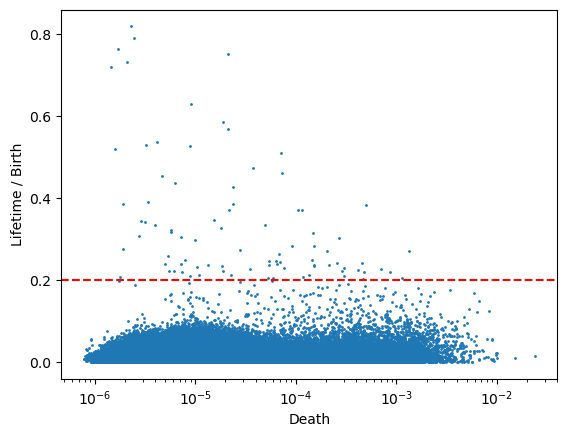

In [54]:
plt.figure()
plt.scatter(hi[:,2],rel_life,s=1)
plt.gca().set_xscale('log')
plt.axhline(y=rel_thresh,c='r',ls='--')
plt.xlabel('Death')
plt.ylabel('Lifetime / Birth')

In [55]:
hi_use = np.where((rel_life >=rel_thresh))
hi_filt = hi[hi_use]
hi_save = np.hstack((hi_filt, np.array(hi_use).reshape(-1,1)))

np.savetxt(f'{odir}{fname}.txt', hi_save)

## STEP 3: segment original image

In [8]:
dim_use = 2
rel_thresh = 0.2
fname = f'{rname}_h{dim_use}_filt_rellife{rel_thresh}'

In [9]:
inds_dir = f'{odir}inds/h{dim_use}/'
if not os.path.isdir(f'{odir}inds/'):
    os.mkdir(f'{odir}inds/')
if not os.path.isdir(inds_dir):
    os.mkdir(inds_dir)

In [14]:
hom = PH.load_from(f'{fname}.txt',odir=odir,data=img)
hi_struc = hom.generators
strucs = Structures(structures=hi_struc, img_shape=np.shape(img), wcs=wcs_img, inds_dir=inds_dir)

In [59]:
img_jnp = jnp.array(img)
strucs.compute_segment(img_jnp)
strucs.compute_hierarchy(clobber=True)
strucs.export_struc_map(fname=fname, odir=odir)

  0%|          | 0/87 [00:00<?, ?structures/s]/Users/toneill/Repos/perch/perch/perch_structures.py:314: RuntimeWarning: All-NaN slice encountered
  parent_cand = np.nanmax(mask_s[struc_multi_inds])
100%|██████████| 87/87 [00:36<00:00,  2.39structures/s]


In [15]:
img_jnp = jnp.array(img)
strucs.compute_segment_hierarchy(img_jnp)


  0%|          | 0/87 [00:00<?, ?structures/s]

TypeError: Structure.compute_segment() got an unexpected keyword argument 'verbose'

Text(0.5, 1.0, 'Perch structures (by ID)')

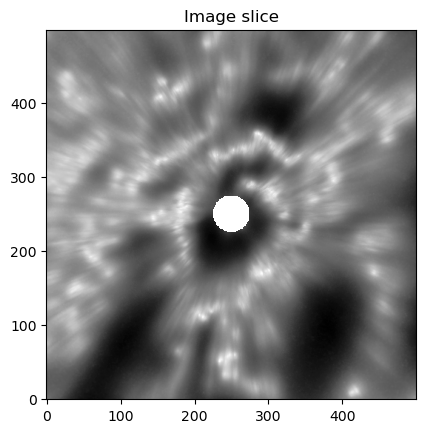

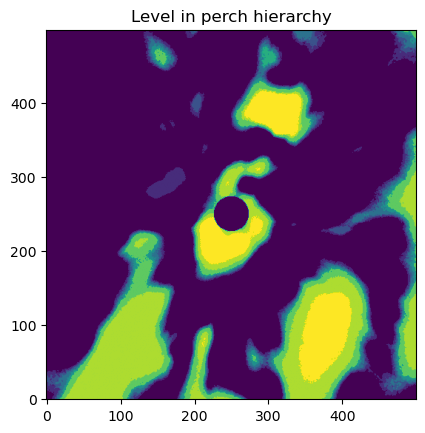

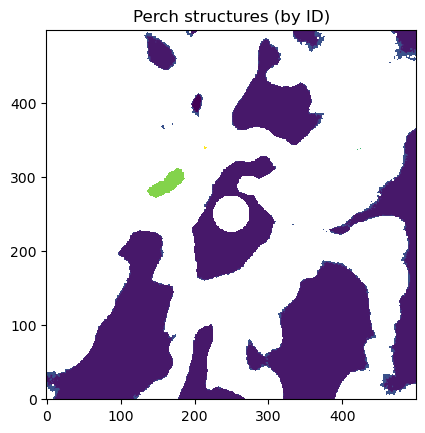

In [72]:
slice_show = 225

plt.figure()
plt.imshow(np.log10(img[slice_show,:,:]),cmap='Greys_r',origin='lower')
plt.title('Image slice')


plt.figure()
plt.imshow(strucs.level_map[slice_show,:,:],cmap='viridis',alpha=1,origin='lower')
plt.title('Level in perch hierarchy')

plt.figure()
plt.imshow(strucs.struc_map[slice_show,:,:],cmap='viridis',alpha=1,origin='lower')
plt.title('Perch structures (by ID)')

